In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
import numpy as np
import gc
from tensorflow.keras.models import model_from_json
!pip install tqdm
!pip install h5py
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [2]:
def scale(x):

    return (x - np.mean(x)) / np.std(x)

In [3]:
def preprocess(x):
    
    return x[:,:,:int(0.75*x.shape[2])]

In [4]:
u = preprocess(scale(loadmat('u_F_xyz_T1.mat')["u_F"]))
v = preprocess(scale(loadmat('v_F_xyz_T1.mat')["v_F"]))
w = preprocess(scale(loadmat('w_F_xyz_T1.mat')["w_F"]))
tau_12 = preprocess(scale(loadmat('tau12_xyz_T1.mat')["tau12"]))
tau_13 = preprocess(scale(loadmat('tau13_xyz_T1.mat')["tau13"]))
tau_23 = preprocess(scale(loadmat('tau23_xyz_T1.mat')["tau23"]))
tke = preprocess(scale(loadmat("TKE_F_xyz_T1.mat")["TKE_F"]))
theta = preprocess(scale(loadmat("theta_F_xyz_T1.mat")["theta_F"]))
p = preprocess(scale(loadmat("pstar_F_xyz_T1.mat")["pstar_F"]))

#### Switches

In [5]:
all_taus = False
significance = True

### 1. Generae Input datasets

#### 1.1 Create Input dataset (u, v, w, TKE, $\theta$)

In [6]:
x = np.array([u, v, w, tke, theta, p])
x = np.transpose(x, [1, 2, 3, 0])
x = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)

In [7]:
sample = []
size = 3
y_tau_12 = []
y_tau_13 = []
y_tau_23 = []
for i in tqdm_notebook(range(size, x.shape[0] - size)):
    for j in range(size, x.shape[1] - size):
        for k in range(size, x.shape[2] - size):
            sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
            y_tau_12.append(tau_12[i - size][j - size][k - size])
            y_tau_13.append(tau_13[i - size][j - size][k - size])
            y_tau_23.append(tau_23[i - size][j - size][k - size])

In [8]:
x = np.stack(sample, axis = 0)
print(x.shape)

y_tau_12 = np.array(y_tau_12)
y_tau_13 = np.array(y_tau_13)
y_tau_23 = np.array(y_tau_23)

del sample
gc.collect()

(784896, 7, 7, 7, 6)


7

#### 1.2 Create Input Dataset (u, v, w, $\theta$)

In [9]:
x_theta = np.delete(x, 3, 4)
print(x_theta.shape)

(784896, 7, 7, 7, 5)


#### 1.3 Create Input Dataset (u, v, w, TKE) 

In [10]:
x_tke = np.delete(x, 4, 4)
print(x_tke.shape)

(784896, 7, 7, 7, 5)


#### 1.4 Create Dataset (u, v, w)

In [11]:
x_base = np.delete(x, (3,4), 4)
print(x_base.shape)

del x
gc.collect()

(784896, 7, 7, 7, 4)


### 2. Build Model 

In [12]:
class DNN(object):
    
    def __init__(self, activation, x_train, y_train, epochs, batch_size, input_shape, val_split, initializer):
        self.activation = activation
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.val_split = val_split
        self.initializer = initializer
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Flatten(input_shape = self.input_shape),
            tf.keras.layers.Dense(128, 
                             activation = self.activation,
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, 
                             activation = self.activation,
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, 
                             activation = self.activation,
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dense(1)
        ])
        
        return model
    
    def callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               min_delta = 0.001,
                                               patience = 0,
                                               verbose = 0)
        
        return early_stopping
    
    def run_model(self):
        model = self.create_model()
        model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss = "mse")
            
        history = model.fit(self.x_train, self.y_train, 
                    epochs = self.epochs, 
                    validation_split = self.val_split, 
                    batch_size =  self.batch_size,
                    verbose = 0)
                    #callbacks = [self.callbacks()])
        
        return history, model

### 3. Run Model

Using x_base as input
R^2: 0.6615
Correlation: 0.8449

Using x_tke as input
R^2: 0.6705
Correlation: 0.8428

Using x_theta as input
R^2: 0.6077
Correlation: 0.8393



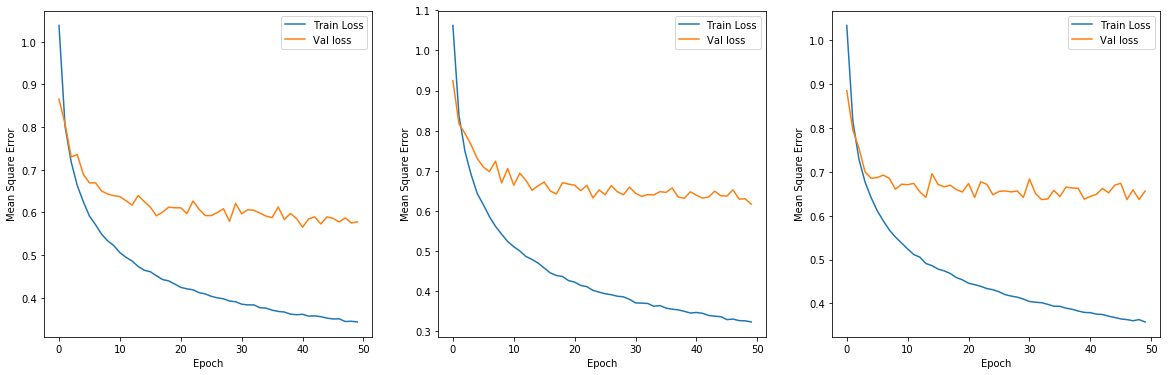

In [13]:
if significance:
    activation = tf.nn.relu
    epochs = 50
    initializer = tf.glorot_uniform_initializer
    batch_size = 1000
    val_split = 0.2

    datasets = [(x_base, "x_base"), (x_tke, "x_tke"), (x_theta, "x_theta")]
    fig = plt.figure(figsize = (20, 6))
    results = {}
    i = 1
    for (x, name) in datasets:
        print("Using " + name + " as input")
        mask =  np.random.rand(x.shape[0]) < 0.80
        y_train, y_test = y_tau_12[mask], y_tau_12[~mask]
        x_train, x_test = x[mask,:,:,:,:], x[~mask,:,:,:,:]

        input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4])
        model = DNN(activation, x_train, y_train, epochs, batch_size, input_shape, val_split, initializer)        
        history, model = model.run_model()
        
        del x_train
        del y_train
        gc.collect()
        
        fig.add_subplot(1, len(datasets), i)
        plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
        plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error')
        plt.legend()

        y_pred = model.predict(x_test).flatten()
        y_true = y_test
        print("R^2: %.4f" % r2_score(y_true, y_pred))
        print("Correlation: %.4f\n" % np.corrcoef(y_pred, y_true)[0, 1])
        results[np.corrcoef(y_pred, y_true)[0, 1]] = (x, name)
        
        del x_test
        del y_test
        del x
        del y_true
        del y_pred
        del model
        gc.collect()
        i += 1

    plt.show()

In [14]:
x_best = results[max(results)][0]
print("Best Predictor: " + results[max(results)][1])
print(x_best.shape)
del results
gc.collect()

Best Predictor: x_base
(784896, 7, 7, 7, 4)


0

Predicting tau_12
R^2: 0.6706
Correlation: 0.8477
Saved model to disk

Predicting tau_13
R^2: 0.6913
Correlation: 0.8967
Saved model to disk

Predicting tau_23
R^2: 0.6817
Correlation: 0.8790
Saved model to disk



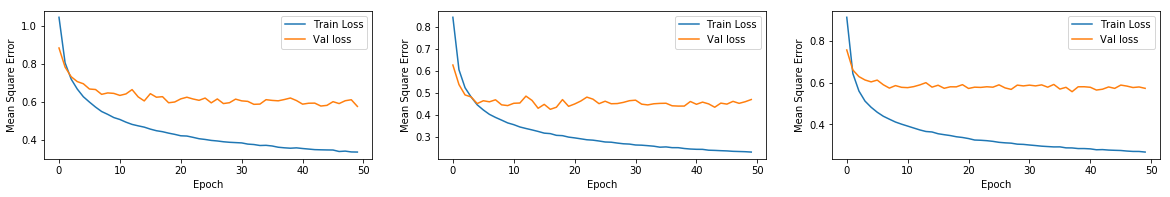

In [16]:
if all_taus:
    taus = [(y_tau_11, "tau_11"), (y_tau_12, "tau_12"), (y_tau_13, "tau_13"), (y_tau_22, "tau_22"), (y_tau_23, "tau_23"), (y_tau_33, "tau_33")]
else:
    taus = [(y_tau_12, "tau_12"), (y_tau_13, "tau_13"), (y_tau_23, "tau_23")]
    
activation = tf.nn.relu
epochs = 50
batch_size = 1000
initializer = None
input_shape = (x_best.shape[1], x_best.shape[2], x_best.shape[3], x_best.shape[4])
val_split = 0.2

fig = plt.figure(figsize = (20, 6))

i = 1
for (y, name) in taus:
    print("Predicting " + name)
    mask =  np.random.rand(x_best.shape[0]) < 0.80
    x_train, x_test = x_best[mask,:,:,:,:], x_best[~mask,:,:,:,:]
    y_train, y_test = y[mask], y[~mask]
    
    model = DNN(activation, x_train, y_train, epochs, batch_size, input_shape, val_split, initializer)
    history, model = model.run_model()
    
    del x_train
    del y_train
    gc.collect()
    
    fig.add_subplot(1, len(datasets), i)
    plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.legend()
    
    y_pred = model.predict(x_test).flatten()
    y_true = y_test
    print("R^2: %.4f" % r2_score(y_true, y_pred))
    print("Correlation: %.4f" % np.corrcoef(y_pred, y_true)[0, 1])
    
    model_name_json = "model_withPressure" + name + ".json"
    model_name_h5 = "model_withPressure" + name + ".h5"
    model_json = model.to_json()
    with open(model_name_json, "w") as json_file:
        json_file.write(model_json)
    model.save(model_name_h5)
    print("Saved model to disk\n")
    
    del x_test
    del y_true
    del y_pred
    del y_test
    del model
    del y
    gc.collect()
    i += 1

plt.show()